<a href="https://colab.research.google.com/gist/ttsalpha/1e490f403b50c5a8721bb8da4607fc38/fashionmnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import numpy as np

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import math
from IPython import display

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hyper-parameters

In [ ]:
latent_size = 100
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100

## Image processing

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = torchvision.datasets.FashionMNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True)

test_dataset = torchvision.datasets.FashionMNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid())

    # forward method
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, image_size, hidden_size, latent_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh())

    # forward method
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [ ]:
# Device setting
D = Discriminator(image_size, hidden_size).to(device)
G = Generator(image_size, hidden_size, latent_size).to(device)

## Binary cross entropy loss and optimizer

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
# draw samples from the input distribution to inspect the generation on training
num_test_samples = 16
test_noise = torch.randn(num_test_samples, latent_size).to(device)

## Create figure for plotting and Start training

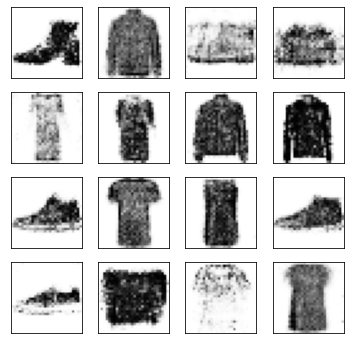

In [38]:
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

epoch_d_losses = []
epoch_g_losses = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    for i, (images, _) in enumerate(train_loader):
        # images = images.view(batch_size, -1).to(device)
        # images = Variable(images)
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================= Train the discriminator ================= #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        d_losses.append(d_loss.item())

        # ================= Train the generator  ================= #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # Train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        g_losses.append(g_loss.item())

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

            test_images = G(test_noise)
            for k in range(num_test_samples):
                i = k // 4
                j = k % 4
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k, :].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            # display.display(plt.gcf())

    epoch_d_losses.append(np.mean(d_losses))
    epoch_g_losses.append(np.mean(g_losses))

## Discrimination loss during training

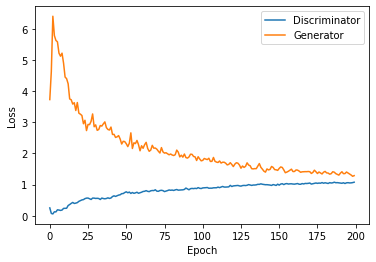

In [39]:
plt.figure()
plt.plot(epoch_d_losses)
plt.plot(epoch_g_losses)
plt.legend(['Discriminator', 'Generator'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()